In [38]:
import random
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
pipelines = pd.read_csv('./df_pipe.csv', header=0, index_col=0, sep=';').dropna().reset_index(drop=True)
pipelines

,Source,Target
0,switch_greeting,switch_pa
1,switch_greeting,switch_step_count
2,switch_greeting,switch_memory_recall
3,switch_greeting,switch_goal_setting
4,switch_memory_recall,switch_step_count
5,switch_memory_recall,switch_pa
6,switch_memory_recall,switch_goal_setting
7,switch_memory_recall,switch_rating_importance
8,switch_pa,switch_rating_importance
9,switch_pa,switch_rating_confidence


In [40]:
G = nx.from_pandas_edgelist(pipelines, "Source", "Target", create_using=nx.DiGraph())

print(f'directed graph: {nx.is_directed(G)}')
print(f'number of nodes is: {len(G)}')

all_nodes = list(G.nodes())
print(f'all_nodes is: {all_nodes}')

directed graph: True
number of nodes is: 9
all_nodes is: ['switch_greeting', 'switch_pa', 'switch_step_count', 'switch_memory_recall', 'switch_goal_setting', 'switch_rating_importance', 'switch_rating_confidence', 'switch_self_efficacy', 'switch_motivator']


In [41]:
# function to generate random walk sequences of given node
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk


random_walk = get_randomwalk('switch_pa', 10)
random_walk

['switch_pa',
 'switch_rating_importance',
 'switch_self_efficacy',
 'switch_motivator']

In [42]:
# function to generate random walk sequences of given graph G
def get_randomwalk_sequences(G, number_sequence_per_node):
    all_nodes = list(G.nodes())

    random_walks = []
    sentence_length = [2, 4, 6]
    
    for lens in sentence_length:
        for n in tqdm(all_nodes):
            for i in range(number_sequence_per_node): # number of sequences start from one node
                random_walks.append(get_randomwalk(n, lens)) # length of sentence

    return random_walks

random_walks = get_randomwalk_sequences(G, 5)
print(len(random_walks))

random_walks[:3]

100%|██████████| 9/9 [00:00<00:00, 35147.80it/s]

135


[['switch_greeting', 'switch_memory_recall'],
 ['switch_greeting', 'switch_step_count'],
 ['switch_greeting', 'switch_goal_setting']]

In [43]:
# Finding the length of the longest string in our data
maxlen = len(max(random_walks, key=len))
maxlen

6

In [76]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

# train word2vec model
model = Word2Vec(window=3, alpha=0.06)
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=250, report_delay=1)

print(model)

# find top n similar nodes 
model.wv.most_similar('switch_greeting')

Word2Vec(vocab=9, vector_size=100, alpha=0.06)


[('switch_rating_confidence', 0.9958100914955139),
 ('switch_rating_importance', 0.9949781894683838),
 ('switch_goal_setting', 0.9946457743644714),
 ('switch_memory_recall', 0.9938341975212097),
 ('switch_step_count', 0.9931740760803223),
 ('switch_self_efficacy', 0.9926184415817261),
 ('switch_motivator', 0.9914268255233765),
 ('switch_pa', 0.9905545711517334)]

In [77]:
sim_mat = model.wv["switch_rating_importance"]
print(np.shape(sim_mat))
sim_mat[:2]

(100,)


array([-0.22020721,  0.18332928], dtype=float32)

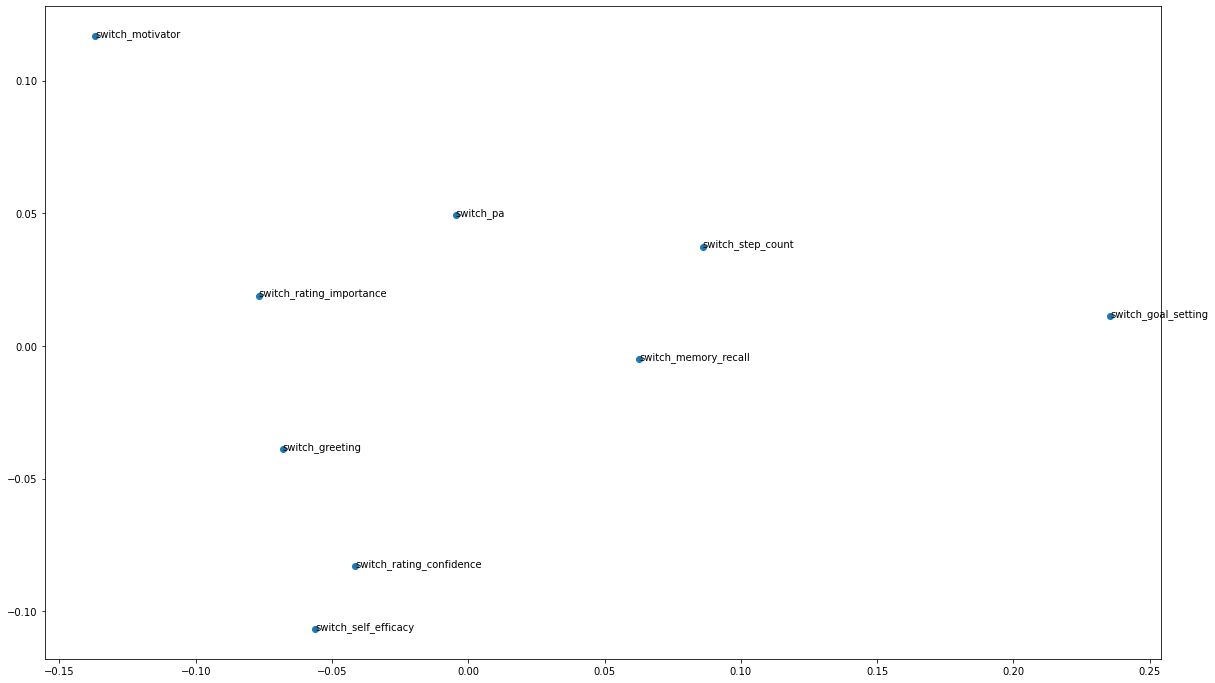

In [78]:
def plot_nodes(word_list, save_name):
    X = model.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(20,12))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    # plt.savefig(save_name)
    plt.show()


plot_nodes(all_nodes, 'all_nodes.jpg')

(9, 4)


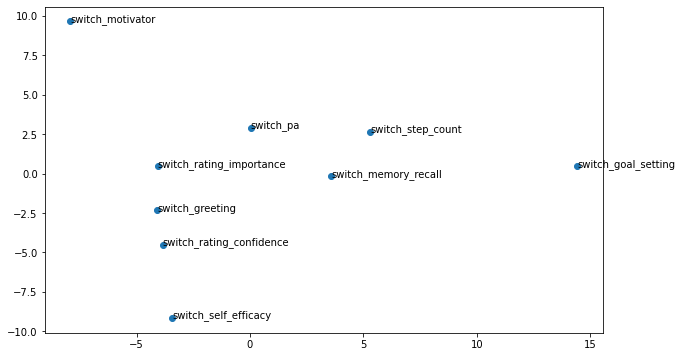

In [79]:
from sklearn.preprocessing import StandardScaler

emb_node = model.wv[all_nodes]

scaler = StandardScaler()
scaler.fit(emb_node)
emb_node_scale = scaler.transform(emb_node)


def plot_emb_sim(X, word_list, save_name):
    #X = model[word_list]
    # reduce dimensions to 2
    pca = PCA(n_components=4)
    result = pca.fit_transform(X)
    print(np.shape(result))
    
    plt.figure(figsize=(10,6))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    # plt.savefig(save_name)
    plt.show()


plot_emb_sim(emb_node_scale, all_nodes, 'emb_node_scale.png')

In [58]:
# np.save('./emb_node.npy', emb_node) 

In [80]:
# calculate and save embedding dict
# emb_node = model.wv[all_nodes]
dict_node_emb = dict()
for i, item in enumerate(all_nodes):
    dict_node_emb[item] = emb_node[i]

# np.save('./dict_node_emb.npy', dict_node_emb) 

In [81]:
print(len(dict_node_emb))
np.shape(dict_node_emb['switch_greeting'])

9


(100,)

In [82]:
# Construct sequence dataset for training and testing
df_flow = pd.DataFrame(random_walks)
df_flow.to_csv('./df_flow.csv')

---

In [85]:
oper2ind = dict()
for i, item in enumerate(all_nodes):
    oper2ind[item] = i

oper2ind['PAD_IDX'] = 9
oper2ind['UNK_IDX'] = 10
oper2ind['BOS'] = 11
oper2ind['EOS'] = 12

ind2oper = dict()
for i, item in enumerate(oper2ind):
    ind2oper[i] = item

print(len(ind2oper))

13


In [87]:
# # save
# file_oper2ind = './oper_ind/oper2ind.npy'
# file_ind2oper = './oper_ind/ind2oper.npy'
# np.save(file_oper2ind, oper2ind)
# np.save(file_ind2oper, ind2oper)

# # load
# d2 = np.load(file_oper2ind, allow_pickle=True).item()

In [91]:
df_flow = df_flow.fillna('PAD_IDX', inplace=False)
df_flow.head(3)

,0,1,2,3,4,5
0,switch_greeting,switch_memory_recall,PAD_IDX,PAD_IDX,PAD_IDX,PAD_IDX
1,switch_greeting,switch_step_count,PAD_IDX,PAD_IDX,PAD_IDX,PAD_IDX
2,switch_greeting,switch_goal_setting,PAD_IDX,PAD_IDX,PAD_IDX,PAD_IDX


### RNN for next operation prediction recom

In [92]:
# get training dataset
df_flow_ids = []
for i in range(len(df_flow)):
    lists = [oper2ind[str(j)] for j in df_flow.iloc[i] if j != 'PAD_IDX']
    #print(lists)
    df_flow_ids.append(lists)

random.shuffle(df_flow_ids)

In [93]:
# Finding the length of the longest string in our data
maxlen = len(max(df_flow_ids, key=len))
maxlen

6

In [94]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_flow_ids, test_size=0.05)
print(len(train))
print(len(test))

128
7


In [95]:
# Creating lists that will hold our input and target sequences
train_input_seq = []
train_target_seq = []
for i in range(len(train)):
    '''
    # Remove last character for input sequence
    train_input_seq.append(train[i][:-1])
    
    # Remove first character for target sequence
    train_target_seq.append(train[i][1:])
    '''
    inputs = []
    target = []
    inputs.extend(train[i][:-1])
    target.extend(train[i][1:])

    while len(inputs) < maxlen:
        inputs.append(oper2ind['PAD_IDX'])

    while len(target) < maxlen:
        target.append(oper2ind['PAD_IDX'])

    train_input_seq.append(inputs)
    train_target_seq.append(target)

    print("Input Sequence: {}\nTarget Sequence: {}".format(train_input_seq[i], train_target_seq[i]))


# Creating lists that will hold our input and target sequences
test_input_seq = []
test_target_seq = []
for i in range(len(test)):
    # Remove last character for input sequence
    inputs = []
    target = []
    inputs.extend(test[i][:-1])
    target.extend(test[i][1:])

    while len(inputs) < maxlen:
        inputs.append(oper2ind['PAD_IDX'])

    while len(target) < maxlen:
        target.append(oper2ind['PAD_IDX'])

    test_input_seq.append(inputs)
    test_target_seq.append(target)
    
    print("Input Sequence: {}\nTarget Sequence: {} {}".format(test_input_seq[i], test_target_seq[i], '\n'))


Input Sequence: [5, 7, 9, 9, 9, 9]
Target Sequence: [7, 8, 9, 9, 9, 9]
Input Sequence: [9, 9, 9, 9, 9, 9]
Target Sequence: [9, 9, 9, 9, 9, 9]
Input Sequence: [9, 9, 9, 9, 9, 9]
Target Sequence: [9, 9, 9, 9, 9, 9]
Input Sequence: [0, 1, 6, 9, 9, 9]
Target Sequence: [1, 6, 8, 9, 9, 9]
Input Sequence: [5, 7, 9, 9, 9, 9]
Target Sequence: [7, 8, 9, 9, 9, 9]
Input Sequence: [5, 6, 9, 9, 9, 9]
Target Sequence: [6, 8, 9, 9, 9, 9]
Input Sequence: [6, 9, 9, 9, 9, 9]
Target Sequence: [8, 9, 9, 9, 9, 9]
Input Sequence: [2, 7, 9, 9, 9, 9]
Target Sequence: [7, 8, 9, 9, 9, 9]
Input Sequence: [1, 9, 9, 9, 9, 9]
Target Sequence: [6, 9, 9, 9, 9, 9]
Input Sequence: [6, 9, 9, 9, 9, 9]
Target Sequence: [8, 9, 9, 9, 9, 9]
Input Sequence: [7, 9, 9, 9, 9, 9]
Target Sequence: [8, 9, 9, 9, 9, 9]
Input Sequence: [0, 1, 5, 6, 9, 9]
Target Sequence: [1, 5, 6, 8, 9, 9]
Input Sequence: [3, 9, 9, 9, 9, 9]
Target Sequence: [4, 9, 9, 9, 9, 9]
Input Sequence: [6, 7, 9, 9, 9, 9]
Target Sequence: [7, 8, 9, 9, 9, 9]
Input 

In [96]:
def embeddings(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features


dict_size = len(oper2ind)
print(dict_size)

seq_len = maxlen - 1
print(seq_len)

train_batch_size = len(train)
print(train_batch_size)

test_batch_size = len(test)
print(test_batch_size)

# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
train_input_seq = embeddings(train_input_seq, dict_size, seq_len, train_batch_size)
train_target_seq = embeddings(train_target_seq, dict_size, seq_len, train_batch_size)

13
5
128
7


In [97]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

train_input_seq = torch.from_numpy(train_input_seq)
train_target_seq = torch.Tensor(train_target_seq)

print(train_input_seq.size())
print(train_target_seq.size())
#print(test_input_seq.size())
#print(test_target_seq.size())

batch_size = 8

train_data = TensorDataset(train_input_seq, train_target_seq)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

torch.Size([128, 5, 13])
torch.Size([128, 5, 13])
GPU not available, CPU used


In [98]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.dropout = nn.Dropout(0.05)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        #print('batch_size: ', x.size())
        batch_size = x.size(0)
        
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        #print('inputs: ', x.size())

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        #print(out.size())
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(out)
        out = self.fc(out)
        #print('output: ', out.size())
        #print(out.size())
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [102]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=64, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

# Define hyperparameters
n_epochs = 400
lr=0.0005

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [103]:
# Training Run
train_loss_all = []

for epoch in range(1, n_epochs + 1):
    epoch_loss = []
    for inputs, labels in train_loader:

        optimizer.zero_grad() # Clears existing gradients from previous epoch

        output, hidden = model(inputs)

        #print('output: ', output.view(-1, dict_size).size())
        #print('target_seq: ', train_target_seq.view(-1, dict_size).size())
        #print('\n')
        #a = torch.max(target_seq.view(-1, dict_size), 1)[1]
        #b = torch.max(output, 1)[1]
        #print(a.size(), b.size())
        #print(a, b)

        loss = criterion(output, torch.max(labels.view(-1, dict_size),1)[1]) #torch.max(train_target_seq[0], 1)[1]) #

        loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly

        # train_loss_all.append(loss.item())
        epoch_loss.append(loss.item())

    train_loss_all.append(np.mean(epoch_loss))

    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Epoch Loss: {:.4f}".format(np.mean(epoch_loss)))
        

Epoch: 10/400............. Epoch Loss: 0.7926
Epoch: 20/400............. Epoch Loss: 0.5532
Epoch: 30/400............. Epoch Loss: 0.4086
Epoch: 40/400............. Epoch Loss: 0.3232
Epoch: 50/400............. Epoch Loss: 0.2698
Epoch: 60/400............. Epoch Loss: 0.2402
Epoch: 70/400............. Epoch Loss: 0.2242
Epoch: 80/400............. Epoch Loss: 0.2078
Epoch: 90/400............. Epoch Loss: 0.2026
Epoch: 100/400............. Epoch Loss: 0.1986
Epoch: 110/400............. Epoch Loss: 0.1901
Epoch: 120/400............. Epoch Loss: 0.1900
Epoch: 130/400............. Epoch Loss: 0.1878
Epoch: 140/400............. Epoch Loss: 0.1849
Epoch: 150/400............. Epoch Loss: 0.1844
Epoch: 160/400............. Epoch Loss: 0.1840
Epoch: 170/400............. Epoch Loss: 0.1795
Epoch: 180/400............. Epoch Loss: 0.1832
Epoch: 190/400............. Epoch Loss: 0.1771
Epoch: 200/400............. Epoch Loss: 0.1766
Epoch: 210/400............. Epoch Loss: 0.1764
Epoch: 220/400........

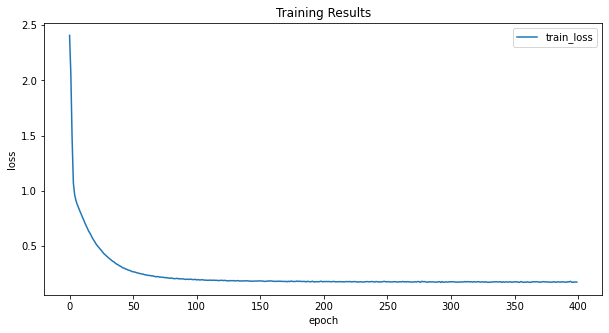

In [104]:
def plot_loss(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='train_loss')
    plt.legend()
    plt.title('Training Results')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

plot_loss(train_loss_all)

In [106]:
PATH = './model/model_rnn.pt'

# save
torch.save(model.state_dict(), PATH)

'''
# load
model = Seq2Seq(encoder, decoder)   # TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''

'\n# load\nmodel = Seq2Seq(encoder, decoder)   # TheModelClass(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n'

In [107]:
# load
PATH = './model/model_rnn.pt'
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=64, n_layers=1)   # TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

Model(
  (rnn): RNN(13, 64, batch_first=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (fc): Linear(in_features=64, out_features=13, bias=True)
)

In [108]:
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, operation):
    # One-hot encoding our input to fit into the model
    
    operation = np.array([[oper2ind[oper] for oper in operation]])
    operation = embeddings(operation, dict_size, operation.shape[1], 1)
    operation = torch.from_numpy(operation)
    operation.to(device)
    
    out, hidden = model(operation)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    oper_ind = torch.max(prob, dim=0)[1].item()

    return ind2oper[oper_ind], hidden


# This function takes the desired output length and input characters as arguments, returning the produced sentence
# This function will output next out_len prediction results
def sample(model, out_len, start):
    model.eval() # eval mode
    #start = start.lower()
    # First off, run through the starting characters
    opers = [oper for oper in start]
    size = out_len - len(opers)
    res = []
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        pred_oper, h = predict(model, opers)
        #if pred_oper == 'PAD_IDX':
         #   break
        opers.append(pred_oper)
        res.append(pred_oper)
    return ', '.join(res)

In [109]:
res1 = sample(model, 5, ['switch_greeting', 'switch_pa'])
res2 = sample(model, 5, ['switch_greeting', 'switch_pa', 'switch_rating_importance'])
res3 = sample(model, 5, ['switch_rating_importance', 'switch_rating_confidence'])
res4 = sample(model, 5, ['switch_step_count', 'switch_goal_setting'])

In [110]:
print('res1: ', res1, '\n')
print('res2: ', res2, '\n')
print('res3: ', res3, '\n')
print('res4: ', res4, '\n')

res1:  switch_rating_importance, switch_rating_confidence, switch_motivator 

res2:  switch_rating_confidence, switch_motivator 

res3:  switch_self_efficacy, switch_motivator, PAD_IDX 

res4:  switch_self_efficacy, switch_motivator, PAD_IDX 



---

In [27]:
all_pipelines = {"switch_greeting": 1,
                 "switch_pa": 2, 
                 "switch_step_count": 6, 
                 "switch_memory_recall": 4, 
                 "switch_goal_setting": 3,
                 "switch_rating_importance": 9, 
                 "switch_rating_confidence": 7, 
                 "switch_self_efficacy": 8, 
                 "switch_motivator": 5
                } 

sorted_pipelines = dict(sorted(all_pipelines.items(), key=lambda x: x[1], reverse=False))

In [35]:
sorted_pipelines.values() #[-1]

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9])